In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [179]:
# raw_communities = pd.read_csv('../Data/communities.csv')
# raw_egm = pd.read_csv("../Data/EGM.csv")
# raw_houses = pd.read_csv("../Data/Houses-by-suburb.csv")
# raw_all_offences = pd.read_excel("../Data/LGA_Offences.xlsx", sheet_name=None)
# raw_offense = raw_all_offences['Table 01']

raw_egm = pd.read_csv('../cleanedCsv/cleandEGM.csv', index_col=0)
raw_offense = pd.read_csv('../cleanedCsv/cleanedOffences.csv', index_col=0)
# raw_egm


In [180]:
from bs4 import BeautifulSoup
import requests

url = "https://www.vec.vic.gov.au/electoral-boundaries/local-councils"
doc = requests.get(url).text

In [181]:
soup = BeautifulSoup(doc, 'html.parser')
base = soup.find('h3', string='A')

def clean_lga(lga: str):
    lga = lga.strip().lower()
    lga = lga.replace('-', ' ')

    replaces = {
        'moreland': 'merribek'
    }
    lga = ''.join([replaces.get(word, word) for word in lga.split() if word not in ['of', 'city', 'rural', 'shire', 'borough']])

    return lga

lgas = []
for link in base.find_all_next('a'):
    text = link.text.strip()
    if text == '':
        continue
    
    lgas.append(clean_lga(' '.join(text.split(' ')[:-1]).lower()))
    if text == 'Yarriambiack Shire Council':
        break

lgas = np.unique(lgas)

@np.vectorize
def islga(name):
    for t in lgas:
        if name in t:
            return True
        
    return False

lgas[:5]

array(['alpine', 'ararat', 'ballarat', 'banyule', 'basscoast'],
      dtype='<U19')

In [182]:
lgas

array(['alpine', 'ararat', 'ballarat', 'banyule', 'basscoast', 'bawbaw',
       'bayside', 'benalla', 'boroondara', 'brimbank', 'buloke',
       'campaspe', 'cardinia', 'casey', 'centralgoldfields', 'colacotway',
       'corangamite', 'darebin', 'eastgippsland', 'frankston',
       'gannawarra', 'gleneira', 'glenelg', 'goldenplains',
       'greaterbendigo', 'greaterdandenong', 'greatergeelong',
       'greatershepparton', 'hepburn', 'hindmarsh', 'hobsonsbay',
       'horsham', 'hume', 'indigo', 'kingston', 'knox', 'latrobe',
       'loddon', 'macedonranges', 'manningham', 'mansfield',
       'maribyrnong', 'maroondah', 'melbourne', 'melton', 'merribek',
       'mildura', 'mitchell', 'moira', 'monash', 'mooneevalley',
       'moorabool', 'morningtonpeninsula', 'mountalexander', 'moyne',
       'murrindindi', 'nillumbik', 'northerngrampians', 'portphillip',
       'pyrenees', 'queenscliffe', 'southerngrampians', 'southgippsland',
       'stonnington', 'strathbogie', 'surfcoast', 'swanhi

In [183]:
import re

# clean egm
def clean_egm(egm):
    print("CLEANING EGM")
    egm = egm.copy()
    egm = egm.iloc[:57, :]

    egm['LGA'] = egm['LGA Name'].apply(clean_lga)
    egm = egm.drop(['LGA Name'], axis=1)


    # filter only the ones in lgas
    old = pd.unique(egm['LGA'])
    egm = egm.query('@islga(LGA)')
    n = pd.unique(egm['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")

    display(egm.head())

    return egm


def clean_offenses(crime):
    print('CLEANING OFFENSES')
    crime = crime.copy()
    crime = crime[crime['Local Government Area'] != 'Total']
    crime['LGA'] = crime['Local Government Area'].apply(lambda s: clean_lga(s.lower().strip()))
    crime = crime.drop(['Local Government Area'], axis=1)

    # filter only the ones in lgas
    old = pd.unique(crime['LGA'])
    crime = crime.query('@islga(LGA)')
    n = pd.unique(crime['LGA'])

    print(f"removed {np.setdiff1d(old, n)}")
    print(f"{n.size} LGAs")
    display(crime.head())
    return crime

def clean_community(community):
    print('CLEANING COMMUNITY')
    community: pd.DataFrame = community.copy()

    community['LGA'] = community['LGA'].apply(lambda s: "none" if (out := re.search(r"(.*) \(\w+\)", s.strip())) is None else out.group(1))
    community = community[community['LGA'] != "none"]
    community['LGA'] = community['LGA'].apply(clean_lga)

    # aggregate over numeric and categorical
    numerics = set(community.select_dtypes([np.number]).columns)
    categorical = set(community.columns) - numerics
    cat = {
        col: pd.Series.mode for col in categorical if col != 'LGA'
    }
    num = {
        col: pd.Series.sum for col in numerics
    }

    # fix percentages
    numper = [
        col for col in numerics if '%' in col or 'weighted' in col
    ]

    # create population and scale
    population = community['Population Density'] * community['Area (km^2)']
    community['Population'] = population
    community[numper] = community[numper].multiply(population, axis='index')

    # aggergate
    community = community.groupby("LGA").agg({**cat, **num, 'Population': pd.Series.sum})
    
    # rescale population
    community['Population Density'] = community['Population'] / community['Area (km^2)']
    community[numper] = community[numper].divide(community['Population'], axis='index')

    display(community.head(2))
    print(f"unique LGAs {community.shape[0]}")
    return community


def clear_region(region):
    region = region.strip().lower()

    try:
        if '(' in region and ')' in region:
            region = re.search(r"(.*) \([\w\s]+\)", region).group(1)
    except Exception as e:
        print(region)
        raise e
    
    return region

def clean_houses(communities, houses):
    print('CLEANING HOUSES')
    community = communities.copy()

    community['Locality'] = community['Community Name'].apply(clear_region)
    houses['Locality'] = houses['Locality'].apply(clear_region)
    houses = houses.set_index('Locality')

    # clear na and - drops, impute data
    houses = houses.dropna()
    houses = houses[~houses.isin(['-']).any(axis=1)]
    houses = houses.apply(pd.to_numeric)

    houses.rename(columns=lambda c: c + ' weighted', inplace=True)

    print(f'Rows before {community.shape[0]}')

    # join houses into community, TODO: this might repeat them?
    community = community.join(houses, on='Locality', how='inner')

    print(f'Rows after {community.shape[0]}')
    display(community.head(2))

    return community


print(f'total LGAs {len(lgas)}')
offense = clean_offenses(raw_offense)
egm = clean_egm(raw_egm)


total LGAs 79
CLEANING OFFENSES
removed ['total']
66 LGAs


,Year,Population,Offence Count,"Rate per 100,000 population",LGA
0,2014,18337.144047,663.0,3615.612106,alpine
1,2014,99913.976813,10221.0,10229.800000,ballarat
2,2014,125106.800196,8932.0,7139.500000,banyule
3,2014,31917.005857,2572.0,8058.400000,basscoast
4,2014,46643.732478,3810.0,8168.300000,bawbaw


CLEANING EGM
removed []
57 LGAs


,Region,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,LGA
0,M,1.095429e+08,1.115836e+08,1.010001e+08,1.035006e+08,1.091612e+08,1.116516e+08,1.152932e+08,1.184756e+08,1.207063e+08,91066518.95,72128889.57,1.049100e+08,1.474469e+08,whittlesea
1,C,1.071793e+07,1.121941e+07,1.014142e+07,1.035065e+07,1.003788e+07,9.050693e+06,9.105582e+06,9.720508e+06,9.200584e+06,7004272.36,5460348.53,7.816159e+06,1.109367e+07,northerngrampians
2,C,1.184686e+08,1.183161e+08,1.097196e+08,1.116281e+08,1.130210e+08,1.132050e+08,1.154188e+08,1.188324e+08,1.203854e+08,89137264.73,70561866.77,1.055019e+08,1.355966e+08,greatergeelong
3,C,1.105642e+07,1.091608e+07,1.019461e+07,1.007489e+07,1.026330e+07,1.016289e+07,1.023095e+07,1.024279e+07,1.075162e+07,8316806.76,5925575.86,9.067925e+06,1.102290e+07,colacotway
4,C,1.083741e+07,1.116534e+07,1.054645e+07,1.030988e+07,1.057564e+07,1.061337e+07,1.139579e+07,1.196206e+07,1.234074e+07,9631820.68,7713038.67,1.214007e+07,1.450908e+07,moorabool


In [185]:
raw_community = pd.read_csv('../cleanedCsv/cleanedCommunities.csv')
raw_housing = pd.read_csv('../cleanedCsv/weightedHousingPrice.csv')

In [195]:
from IPython.display import display

# unpivot housing and egm
housing = pd.melt(raw_housing, id_vars=['LGA'], value_vars=[str(year) for year in range(2013,2023+1)], value_name='Median House Price', var_name='Year')
display(housing.head())

cleaned_egm = pd.melt(egm, id_vars=['LGA'], value_vars=[str(year) for year in range(2011, 2023+1)], value_name='EGM', var_name='Year')
display(cleaned_egm.head())

,LGA,Year,Median House Price
0,alpine,2013,232888.888889
1,ballarat,2013,552466.572467
2,banyule,2013,653361.591387
3,basscoast,2013,320354.166667
4,bawbaw,2013,384649.880211


,LGA,Year,EGM
0,whittlesea,2011,1.095429e+08
1,northerngrampians,2011,1.071793e+07
2,greatergeelong,2011,1.184686e+08
3,colacotway,2011,1.105642e+07
4,moorabool,2011,1.083741e+07


In [196]:
cleaned_egm

,LGA,Year,EGM
0,whittlesea,2011,1.095429e+08
1,northerngrampians,2011,1.071793e+07
2,greatergeelong,2011,1.184686e+08
3,colacotway,2011,1.105642e+07
4,moorabool,2011,1.083741e+07
...,...,...,...
736,maribyrnong,2023,6.611950e+07
737,stonnington,2023,2.032712e+07
738,gleneira,2023,7.049928e+07
739,bayside,2023,1.388635e+07


In [197]:
import sqlite3

def to_db(df: pd.DataFrame, name):
    cnx = sqlite3.connect('./data.sqlite3')
    df.to_sql(name=name, con=cnx, if_exists='replace')
    cnx.close()


to_db(offense, 'offense')
to_db(cleaned_egm, 'egm')
to_db(raw_community, 'community')
to_db(housing, 'housing')

# run sql
def inner():
    with sqlite3.connect('./data.sqlite3') as cnx:
        sql = """
    select
        egm.LGA as "LGA", egm.Year, egm.EGM,
        housing."Median House Price",
        offense."Offence Count", offense."Rate per 100,000 population",
        community.*
    from egm
    inner join offense on egm.LGA = offense.LGA and offense.Year = egm.Year
    inner join community on community.LGA = egm.LGA
    inner join housing on housing.LGA = egm.LGA and housing.Year = egm.Year;
    """
        tables = pd.read_sql_query(sql, cnx)
        display(tables.head())
        tables = tables.drop(columns=['index']).copy()
        tables = tables.loc[:, ~tables.columns.duplicated()].copy()
        display(tables.head())

    tables.to_csv('final.csv')
    print(len(tables['LGA'].unique()), 'unique LGAs')

def outer():
    with sqlite3.connect('./data.sqlite3') as cnx:
        sql = """
    select
        egm.LGA as "LGA", egm.Year, egm.EGM,
        housing."Median House Price",
        offense."Offence Count", offense."Rate per 100,000 population",
        community.*
    from egm
    left join offense on egm.LGA = offense.LGA and offense.Year = egm.Year
    left join community on community.LGA = egm.LGA
    left join housing on housing.LGA = egm.LGA and housing.Year = egm.Year;
    """
        tables = pd.read_sql_query(sql, cnx)
        display(tables.tail())
        tables = tables.drop(columns=['index']).copy()
        tables = tables.loc[:, ~tables.columns.duplicated()].copy()
        display(tables.tail())
        display(tables['Year'].describe())

    tables.to_csv('final_outer.csv')
    print(len(tables['LGA'].unique()), 'unique outer LGAs')


inner()
outer()

,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",index,LGA,Travel time to GPO (minutes),Area (km^2),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
0,whittlesea,2014,1.035006e+08,435057.570595,15642.0,6223.597997,60,whittlesea,35.366070,937.879053,...,18.561503,0.256817,18.036673,0.207232,0.477204,78439.0,240336.0,18.046425,17.204576,0
1,northerngrampians,2014,1.035065e+07,185500.000000,1954.0,8372.959438,48,northerngrampians,172.320658,11420.312345,...,32.045696,0.079029,72.888791,0.279198,0.512197,12721.0,25046.0,-181.409591,75.763633,1
2,greatergeelong,2014,1.116281e+08,415601.461751,18635.0,8077.091707,23,greatergeelong,62.298568,1399.303494,...,12.444651,0.248650,12.444651,0.234117,0.574299,111225.0,253712.0,-48.877232,-36.689912,0
3,colacotway,2014,1.007489e+07,267730.769231,2205.0,5884.569448,14,colacotway,155.599695,6949.122615,...,33.789055,0.087821,73.760886,0.321983,0.521732,19819.0,38476.0,-143.760624,-63.459617,1
4,moorabool,2014,1.030988e+07,333450.000000,2537.0,5485.399100,45,moorabool,67.836386,3529.342662,...,22.445167,0.255748,34.709761,0.299067,0.608477,27472.0,63532.0,-69.117859,32.161270,1


,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
0,whittlesea,2014,1.035006e+08,435057.570595,15642.0,6223.597997,35.366070,937.879053,0.006308,0.058839,...,18.561503,0.256817,18.036673,0.207232,0.477204,78439.0,240336.0,18.046425,17.204576,0
1,northerngrampians,2014,1.035065e+07,185500.000000,1954.0,8372.959438,172.320658,11420.312345,1.868060,2.633152,...,32.045696,0.079029,72.888791,0.279198,0.512197,12721.0,25046.0,-181.409591,75.763633,1
2,greatergeelong,2014,1.116281e+08,415601.461751,18635.0,8077.091707,62.298568,1399.303494,0.159625,0.230437,...,12.444651,0.248650,12.444651,0.234117,0.574299,111225.0,253712.0,-48.877232,-36.689912,0
3,colacotway,2014,1.007489e+07,267730.769231,2205.0,5884.569448,155.599695,6949.122615,1.568191,2.174351,...,33.789055,0.087821,73.760886,0.321983,0.521732,19819.0,38476.0,-143.760624,-63.459617,1
4,moorabool,2014,1.030988e+07,333450.000000,2537.0,5485.399100,67.836386,3529.342662,0.444782,0.956087,...,22.445167,0.255748,34.709761,0.299067,0.608477,27472.0,63532.0,-69.117859,32.161270,1


56 unique LGAs


,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",index,LGA,Travel time to GPO (minutes),Area (km^2),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
736,maribyrnong,2023,66119496.54,9.683241e+05,9713.0,10384.4,36,maribyrnong,11.629266,31.347530,...,9.400755,0.303983,10.054296,0.208339,0.644326,33248.0,81443.0,-7.275384,1.522394,0
737,stonnington,2023,20327117.51,2.928361e+06,11214.0,10020.7,52,stonnington,9.937739,23.986985,...,11.066799,0.170484,6.007118,0.146659,0.566706,46028.0,96855.0,4.834074,-4.292877,0
738,gleneira,2023,70499276.13,1.687462e+06,7662.0,4948.3,18,gleneira,15.409791,41.586761,...,10.105238,0.172941,9.112937,0.217295,0.534620,62435.0,150761.0,6.103827,-8.569276,0
739,bayside,2023,13886353.15,1.973979e+06,5605.0,5422.0,5,bayside,20.118347,35.882194,...,4.980725,0.229906,4.980725,0.280488,0.571288,38495.0,97337.0,5.883758,-14.204648,0
740,mooneevalley,2023,85197625.77,1.413503e+06,8020.0,6354.3,44,mooneevalley,13.016887,50.700036,...,8.219363,0.228649,10.281595,0.200171,0.563098,46767.0,115655.0,-5.548091,7.139844,0


,LGA,Year,EGM,Median House Price,Offence Count,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),...,Time to nearest public hospital with maternity services,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category
736,maribyrnong,2023,66119496.54,9.683241e+05,9713.0,10384.4,11.629266,31.347530,0.0,0.0,...,9.400755,0.303983,10.054296,0.208339,0.644326,33248.0,81443.0,-7.275384,1.522394,0
737,stonnington,2023,20327117.51,2.928361e+06,11214.0,10020.7,9.937739,23.986985,0.0,0.0,...,11.066799,0.170484,6.007118,0.146659,0.566706,46028.0,96855.0,4.834074,-4.292877,0
738,gleneira,2023,70499276.13,1.687462e+06,7662.0,4948.3,15.409791,41.586761,0.0,0.0,...,10.105238,0.172941,9.112937,0.217295,0.534620,62435.0,150761.0,6.103827,-8.569276,0
739,bayside,2023,13886353.15,1.973979e+06,5605.0,5422.0,20.118347,35.882194,0.0,0.0,...,4.980725,0.229906,4.980725,0.280488,0.571288,38495.0,97337.0,5.883758,-14.204648,0
740,mooneevalley,2023,85197625.77,1.413503e+06,8020.0,6354.3,13.016887,50.700036,0.0,0.0,...,8.219363,0.228649,10.281595,0.200171,0.563098,46767.0,115655.0,-5.548091,7.139844,0


count      741
unique      13
top       2011
freq        57
Name: Year, dtype: object

57 unique outer LGAs


In [199]:
df = pd.read_csv('./final_outer.csv', index_col=0)
df['crime'] = df['Rate per 100,000 population']
df = df.drop(columns=['Rate per 100,000 population'])
df.head()

# dfouter = pd.read_csv('./final_outer.csv', index_col=0)
# dfouter['crime'] = dfouter['Rate per 100,000 population']
# dfouter = dfouter.drop(columns=['Rate per 100,000 population'])
# dfouter.head()

,LGA,Year,EGM,Median House Price,Offence Count,Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),...,"Presentations to emergency departments, 2012-13",Travel time to nearest public hospital with emergency department,Presentations to emergency departments due to injury,Category 4 & 5 emergency department presentations,Number of Dwellings,Population,Location_x,Location_y,ABS remoteness category,crime
0,whittlesea,2011,1.095429e+08,NaN,NaN,35.366070,937.879053,0.006308,0.058839,0.025918,...,0.256817,18.036673,0.207232,0.477204,78439.0,240336.0,18.046425,17.204576,0,NaN
1,northerngrampians,2011,1.071793e+07,NaN,NaN,172.320658,11420.312345,1.868060,2.633152,2.241487,...,0.079029,72.888791,0.279198,0.512197,12721.0,25046.0,-181.409591,75.763633,1,NaN
2,greatergeelong,2011,1.184686e+08,NaN,NaN,62.298568,1399.303494,0.159625,0.230437,0.188364,...,0.248650,12.444651,0.234117,0.574299,111225.0,253712.0,-48.877232,-36.689912,0,NaN
3,colacotway,2011,1.105642e+07,NaN,NaN,155.599695,6949.122615,1.568191,2.174351,1.847313,...,0.087821,73.760886,0.321983,0.521732,19819.0,38476.0,-143.760624,-63.459617,1,NaN
4,moorabool,2011,1.083741e+07,NaN,NaN,67.836386,3529.342662,0.444782,0.956087,0.690579,...,0.255748,34.709761,0.299067,0.608477,27472.0,63532.0,-69.117859,32.161270,1,NaN


In [59]:
plt.rcdefaults()

,Median House Price
Year,
2011,NaN
2012,NaN
2013,467224.934783
2014,486444.450657
2015,538186.357972
2016,632494.254823
2017,722900.402703
2018,719526.264719
2019,712070.907458


             LGA  Median House Price
737  stonnington        2.928361e+06
715   boroondara        2.414438e+06


,EGM
Year,
2011,6.729126e+07
2012,6.812867e+07
2013,6.323206e+07
2014,6.361109e+07
2015,6.545252e+07
2016,6.664609e+07
2017,6.648082e+07
2018,6.869357e+07
2019,6.877017e+07


          LGA          EGM
730  brimbank  172895893.6
726     casey  159240363.3


''

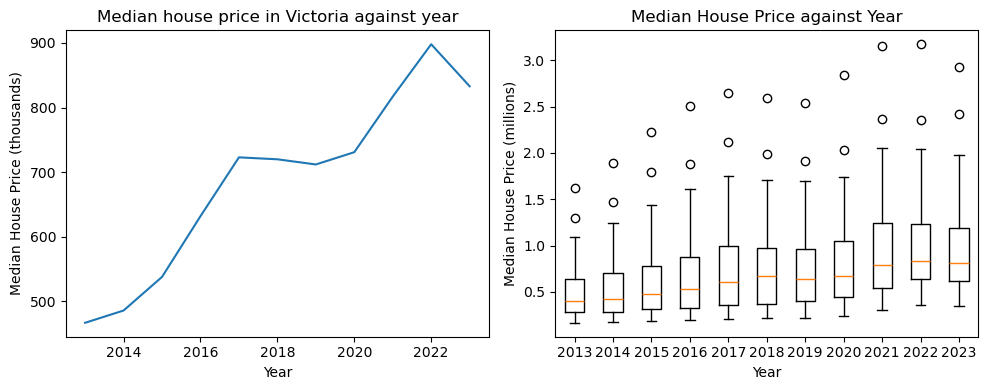

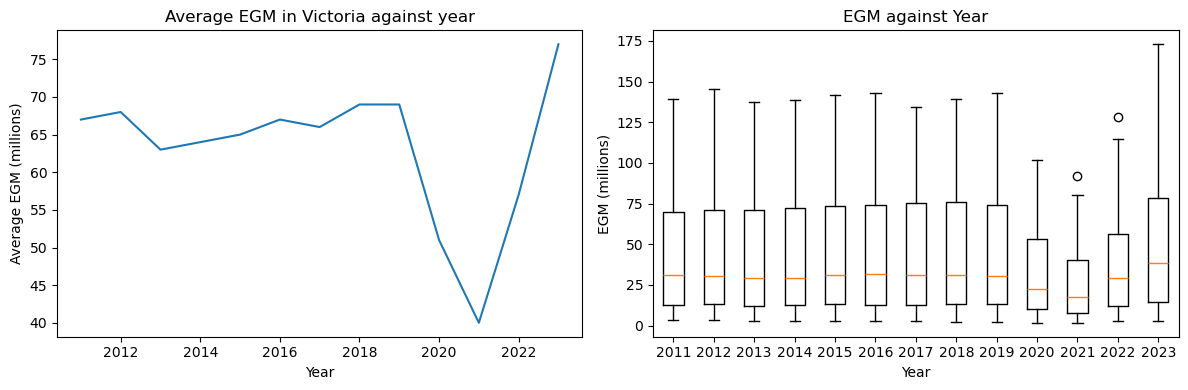

In [217]:
import matplotlib.pyplot as plt

def weighted_median(values, weights):
    i = np.argsort(values)
    c = np.cumsum(weights[i])
    return values[i[np.searchsorted(c, 0.5 * c[-1])]]

# get population histogram
def plot_population():
    out = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    plt.figure()
    plt.boxplot(out['Population'] / 1000, vert=False)
    plt.title('LGA Population Boxplot')
    plt.xlabel("LGA Population (thousands)")
    
def plot_housing():
    # average housing price every year
    raw = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first').copy()
    weighting = raw['Population'] / raw['Population'].sum()
    out = df.groupby('Year').agg({
        "Median House Price": lambda p: weighted_median(p.values, weighting.values)
    })
    display(out)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    ax = axes[0]
    ax.set_title('Median house price in Victoria against year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Median House Price (thousands)')
    ax.plot(np.round(out / 1000))


    raw = df.copy()
    raw = raw[raw['Median House Price'].notna()]

    years = {}
    for year in raw['Year'].unique():
        prices = raw[raw['Year'] == year]
        years[year] = prices['Median House Price'].values / 1e6

    print(prices.nlargest(2, ['Median House Price'])[['LGA', 'Median House Price']])

    ax = axes[1]
    ax.boxplot(years.values(), vert=True)
    ax.set_xticklabels(years.keys())
    ax.set_xlabel("Year")
    ax.set_ylabel("Median House Price (millions)")
    ax.set_title('Median House Price against Year')

    fig.tight_layout()



def plot_housing_year():
    pass


def plot_egm():
    raw = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    weighting = raw['Population'] / raw['Population'].sum()
    out = df.groupby('Year').agg({
        "EGM": lambda p: np.sum(p.values * weighting.values)
    })
    display(out)

    fig, axes = plt.subplots(1,2, figsize=(12,4))

    ax = axes[0]
    ax.set_title('Average EGM in Victoria against year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Average EGM (millions)')
    ax.plot(np.round(out / 1e6))

    years = {}
    for year in df['Year'].unique():
        prices = df[df['Year'] == year]
        years[year] = prices['EGM'].values / 1e6

    print(prices.nlargest(2, ['EGM'])[['LGA', 'EGM']])

    ax = axes[1]
    ax.boxplot(years.values(), vert=True)
    ax.set_xticklabels(years.keys())
    ax.set_xlabel("Year")
    ax.set_ylabel("EGM (millions)")
    ax.set_title('EGM against Year')
    fig.tight_layout()

def plot_egm_year():
    years = {}
    for year in df['Year'].unique():
        prices = df[df['Year'] == year]
        years[year] = prices['EGM'].values / 1e6

    print(prices.nlargest(2, ['EGM'])[['LGA', 'EGM']])

    fig, ax = plt.subplots()
    ax.boxplot(years.values(), vert=True)
    ax.set_xticklabels(years.keys())
    ax.set_xlabel("Year")
    ax.set_ylabel("EGM (millions)")
    ax.set_title('EGM against Year')


def plot_crime():
    raw = df.drop(columns=['Year']).drop_duplicates(subset=['LGA'], keep='first')
    weighting = raw['Population'] / raw['Population'].sum()
    out = df.groupby('Year').agg({
        "crime": lambda p: np.sum(p.values * weighting.values)
    })
    display(out)
    plt.figure()
    plt.title('Average crime rate in Victoria against year')
    plt.xlabel('Year')
    plt.ylabel('Average crime rate (per 100,000)')
    plt.plot(np.round(out))


def plot_crime_year():
    years = {}
    for year in df['Year'].unique():
        prices = df[df['Year'] == year]
        years[year] = prices['crime'].values

    print(prices.nlargest(3, ['crime'])[['LGA', 'crime']])

    fig, ax = plt.subplots()
    ax.boxplot(years.values(), vert=False)
    ax.set_yticklabels(years.keys())
    ax.set_ylabel("Year")
    ax.set_xlabel("Crime rate (per 100,000)")
    ax.set_title('Crime rate against Year')


# plot_population()
plot_housing()
# plot_housing_year()
plot_egm()
# plot_egm_year()
# plot_crime()
# plot_crime_year()
;

Index(['Dental', 'General Practice', 'Homelessness', 'Mental Health',
       'Public Housing Dwellings', 'Dwellings with no motor vehicle',
       'Unemployed, persons', 'crime'],
      dtype='object')


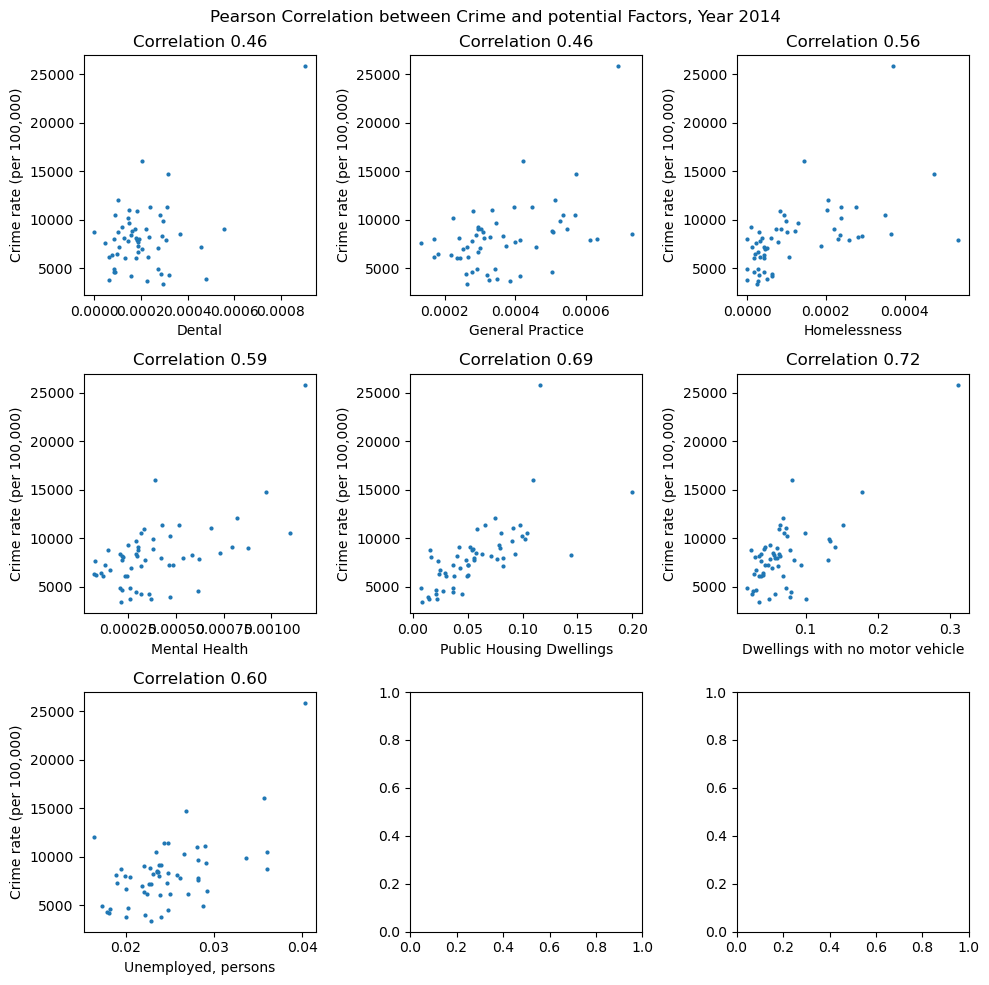

In [158]:
from sklearn.preprocessing import StandardScaler

def correlation_analysis():
    num = df.select_dtypes(include=[np.number])
    num = num.drop(columns=['Offence Count'], axis=1)
    num = num[num['Year'] == 2014]

    corr = num.corr()
    highest = corr[corr['crime'] > 0.4].index
    print(highest)
    filtered = num[highest].copy()

    plots = len(filtered.columns)
    fig, ax = plt.subplots(3, (plots+1)//3, figsize=(10, 10))
    axs = ax.ravel()
    for i, col in enumerate(filtered.columns):
        if col == 'crime':
            continue

        cor = filtered[col].corr(filtered['crime'])
        axs[i].scatter(filtered[col], filtered['crime'], s=4)
        axs[i].set_xlabel(f"{col}")
        axs[i].set_ylabel('Crime rate (per 100,000)')
        axs[i].set_title(f"Correlation {cor:.2f}")

    fig.suptitle('Pearson Correlation between Crime and potential Factors, Year 2014')
    fig.tight_layout()


correlation_analysis()

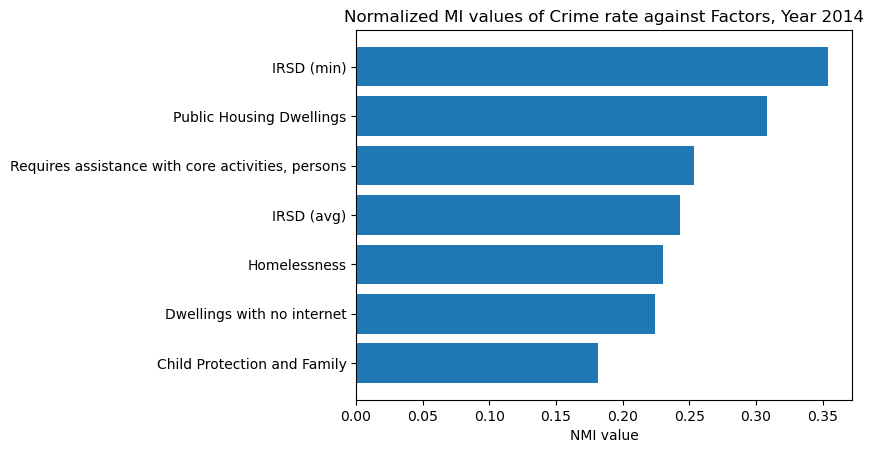

In [159]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import normalized_mutual_info_score
import warnings

def MI_analysis():
    wd = df.copy()
    wd = wd[wd['Year'] == 2014]
    wd = wd.drop(columns=['LGA'])

    warnings.filterwarnings("ignore")
    clusters = KBinsDiscretizer(3, encode='ordinal', strategy='quantile')
    wd[wd.columns] = clusters.fit_transform(wd[wd.columns])
    
    out = {}
    for col in wd.columns:
        if col == 'crime':
            continue

        mi = normalized_mutual_info_score(wd['crime'], wd[col])
        out[col] = mi

    out = {k:v for k, v in sorted(out.items(), key=lambda v: v[1]) if v > 0.15}
    plt.title('Normalized MI values of Crime rate against Factors, Year 2014')
    plt.xlabel('NMI value')
    plt.barh(*zip(*out.items()))


MI_analysis()

    

